In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
import yfinance as yf
from yahoofinancials import YahooFinancials
%matplotlib inline

In [2]:
appl_df = yf.download('AAPL', 
                      start='2018-01-01', 
                      end='2019-12-31', 
                      progress=False)
appl_df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-02,42.540001,43.075001,42.314999,43.064999,41.135750,102223600
2018-01-03,43.132500,43.637501,42.990002,43.057499,41.128590,118071600
2018-01-04,43.134998,43.367500,43.020000,43.257500,41.319633,89738400
2018-01-05,43.360001,43.842499,43.262501,43.750000,41.790073,94640000
2018-01-08,43.587502,43.902500,43.482498,43.587502,41.634853,82271200


<AxesSubplot:title={'center':"Apple's stock price"}, xlabel='Date'>

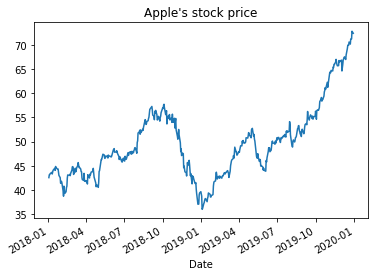

In [3]:
appl_df['Open'].plot(title="Apple's stock price")

<AxesSubplot:title={'center':"Apple's stock return"}, xlabel='Date'>

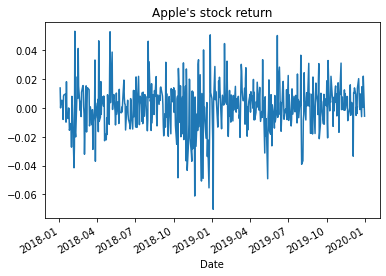

In [4]:
appl_df['Open']=appl_df['Open'].pct_change()
appl_df['Open'].plot(title="Apple's stock return")

In [5]:
sc = StandardScaler()

In [6]:
def preproc( data, lag, ratio):
    data=data.dropna().iloc[:, 0:1]
    Dates=data.index.unique()
    data.iloc[:, 0] = sc.fit_transform(data.iloc[:, 0].values.reshape(-1, 1))
    for s in range(1, lag):
        data['shift_{}'.format(s)] = data.iloc[:, 0].shift(s)
    X_data = data.dropna().drop(['Open'], axis=1)
    y_data = data.dropna()[['Open']]
    index=int(round(len(X_data)*ratio))
    X_data_train=X_data.iloc[:index,:]
    X_data_test =X_data.iloc[index+1:,:]
    y_data_train=y_data.iloc[:index,:]
    y_data_test =y_data.iloc[index+1:,:]
    return X_data_train,X_data_test,y_data_train,y_data_test,Dates;

In [7]:
a,b,c,d,e=preproc(appl_df, 25, 0.90)

In [8]:
a.shape

(429, 24)

In [9]:
spy_df = yf.download('SPY', 
                      start='2018-01-01', 
                      end='2019-12-31', 
                      progress=False)
spy_df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-02,267.839996,268.809998,267.399994,268.769989,250.770050,86655700
2018-01-03,268.959991,270.640015,268.959991,270.470001,252.356140,90070400
2018-01-04,271.200012,272.160004,270.540009,271.609985,253.419785,80636400
2018-01-05,272.510010,273.559998,271.950012,273.420013,255.108643,83524000
2018-01-08,273.309998,274.100006,272.980011,273.920013,255.575150,57319200


<AxesSubplot:title={'center':"Apple's stock return"}, xlabel='Date'>

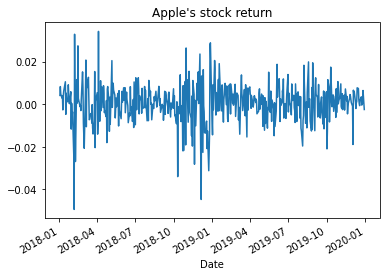

In [41]:
spy_df['Open']=spy_df['Open'].pct_change()
spy_df['Open'].plot(title="Apple's stock return")

In [42]:
def preproc2( data1, data2, lag, ratio):
    common_dates=list(set(data1.index) & set(data2.index))
    data1=data1[data1.index.isin(common_dates)]
    data2=data2[data2.index.isin(common_dates)]
    X1=preproc(data1, lag, ratio)
    X2=preproc(data2, lag, ratio)
    return X1,X2;

In [49]:
dataLSTM=preproc2( spy_df, appl_df, 25, 0.90)

In [44]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import keras.backend as K
from keras.callbacks import EarlyStopping

In [47]:
a = a.values
b= b.values

c = c.values
d = d.values



In [30]:
X_train_t = a.reshape(a.shape[0], 1, 24)
X_test_t = b.reshape(b.shape[0], 1, 24)

In [31]:
X_test_t.shape

(47, 1, 24)

In [32]:
K.clear_session()
early_stop = EarlyStopping(monitor='loss', patience=1, verbose=1)
model = Sequential()
model.add(LSTM(12, input_shape=(1, 24), return_sequences=True))
model.add(LSTM(6))
model.add(Dense(6))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [33]:
model.fit(X_train_t, c,
          epochs=100, batch_size=1, verbose=1,
          callbacks=[early_stop])

Epoch 1/100
429/429 [==============================] - 2s 1ms/step - loss: 1.3043
Epoch 2/100
429/429 [==============================] - 0s 1ms/step - loss: 0.9467
Epoch 3/100
429/429 [==============================] - 0s 1ms/step - loss: 1.1288
Epoch 4/100
429/429 [==============================] - 0s 1ms/step - loss: 0.9817
Epoch 5/100
429/429 [==============================] - 0s 1ms/step - loss: 0.9464
Epoch 6/100
429/429 [==============================] - 0s 1ms/step - loss: 0.9531
Epoch 7/100
429/429 [==============================] - 0s 1ms/step - loss: 0.7813
Epoch 8/100
429/429 [==============================] - 0s 1ms/step - loss: 0.7439
Epoch 9/100
429/429 [==============================] - 0s 1ms/step - loss: 0.5139
Epoch 10/100
429/429 [==============================] - 0s 1ms/step - loss: 0.4443
Epoch 11/100
429/429 [==============================] - 0s 1ms/step - loss: 0.3916
Epoch 12/100
429/429 [==============================] - 0s 1ms/step - loss: 0.3264
Epoch 13/100


In [34]:
ypredr=[]
st=X_test_t[0].reshape(1, 1, 24)
tmp=st
ptmp=st
val=model.predict(st)
ypredr.append(val.tolist()[0])
for i in range(1, X_test_t.shape[0]):
    tmp=np.append(val, tmp[0,0, 0:-1])
    tmp=tmp.reshape(1, 1, 24)
    ptmp=np.vstack((ptmp,tmp))
    val=model.predict(tmp)
    ypredr.append(val.tolist()[0])

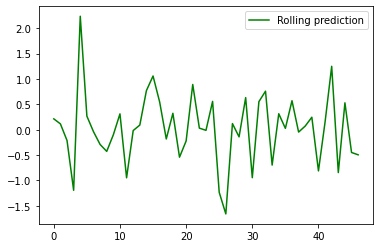

In [35]:
plt.plot(ypredr,color="green", label = "Rolling prediction")
plt.legend()
plt.show()

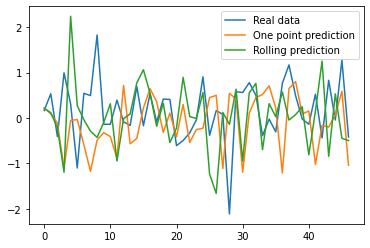

In [36]:
y_pred = model.predict(X_test_t)
plt.plot(d, label = "Real data")
plt.plot(y_pred, label = "One point prediction")
plt.plot(ypredr, label = "Rolling prediction")
plt.legend()
plt.show()

In [50]:
Aa = dataLSTM[0][0].values
Ab = dataLSTM[0][1].values

Ac = dataLSTM[0][2].values
Ad = dataLSTM[0][3].values
X_train_A = Aa.reshape(Aa.shape[0], 1, 24)
X_test_A = Ab.reshape(Ab.shape[0], 1, 24)

In [51]:
Sa = dataLSTM[1][0].values
Sb = dataLSTM[1][1].values

Sc = dataLSTM[1][2].values
Sd = dataLSTM[1][3].values
X_train_S = Sa.reshape(Sa.shape[0], 1, 24)
X_test_S = Sb.reshape(Sb.shape[0], 1, 24)

In [52]:
from keras.layers import concatenate
from keras.layers import Dropout
from keras.models import Sequential
from keras.layers import Dense
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.layers import LSTM
from keras.models import Input, Model
from keras.layers import Dense



In [53]:
early_stop = EarlyStopping(monitor='loss', patience=1, verbose=1)
input1 = Input(shape=(1,24)) # for the three columns of dat_train
x1 = LSTM(6)(input1)

input2 = Input(shape=(1,24))
x2 = LSTM(6)(input2)

con = concatenate(inputs = [x1,x2] ) # merge in metadata
x3 = Dense(50)(con)
x3 = Dropout(0.3)(x3)
output = Dense(1, activation='sigmoid')(x3)
n_net = Model(inputs=[input1, input2], outputs=output)
n_net.compile(loss='mean_squared_error', optimizer='adam')

In [55]:
n_net.fit(x=[X_train_A, X_train_S], y=Ac, epochs=100, batch_size=1, verbose=1,
          callbacks=[early_stop])

Epoch 1/100
429/429 [==============================] - 0s 832us/step - loss: 0.7942
Epoch 2/100
429/429 [==============================] - 0s 808us/step - loss: 0.7825
Epoch 3/100
429/429 [==============================] - 0s 819us/step - loss: 0.7702
Epoch 4/100
429/429 [==============================] - 0s 792us/step - loss: 0.7589
Epoch 5/100
429/429 [==============================] - 0s 786us/step - loss: 0.7517
Epoch 6/100
429/429 [==============================] - 0s 787us/step - loss: 0.7463
Epoch 7/100
429/429 [==============================] - 0s 817us/step - loss: 0.7421
Epoch 8/100
429/429 [==============================] - 0s 805us/step - loss: 0.7372
Epoch 9/100
429/429 [==============================] - 0s 798us/step - loss: 0.7301
Epoch 10/100
429/429 [==============================] - 0s 792us/step - loss: 0.7260
Epoch 11/100
429/429 [==============================] - 0s 821us/step - loss: 0.7236
Epoch 12/100
429/429 [==============================] - 0s 820us/step - lo

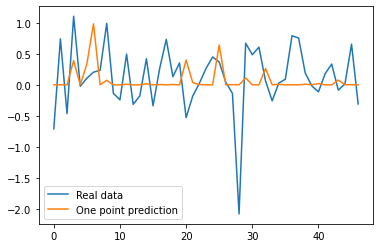

In [56]:
y_pred = n_net.predict([X_test_A,X_test_S])
plt.plot(Ad, label = "Real data")
plt.plot(y_pred, label = "One point prediction")
plt.legend()
plt.show()

In [57]:
ypredr=[]
st=X_test_A[0].reshape(1, 1, 24)
sst=X_test_S[0].reshape(1, 1, 24)
tmp=st
ptmp=st
val=n_net.predict([tmp,sst])
ypredr.append(val.tolist()[0])
for i in range(1, X_test_t.shape[0]):
    tmp=np.append(val, tmp[0,0, 0:-1])
    tmp=tmp.reshape(1, 1, 24)
    sst=X_test_S[i].reshape(1, 1, 24)
    ptmp=np.vstack((ptmp,tmp))
    val=n_net.predict([tmp,sst])
    ypredr.append(val.tolist()[0])

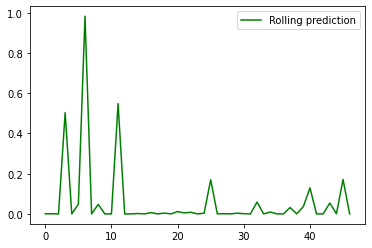

In [58]:
plt.plot(ypredr, color="green", label = "Rolling prediction")
plt.legend()
plt.show()

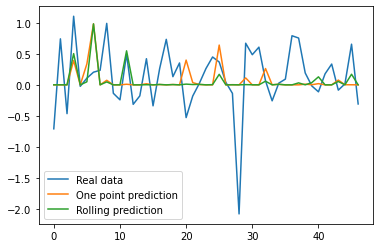

In [59]:
y_pred = n_net.predict([X_test_A,X_test_S])
plt.plot(Ad, label = "Real data")
plt.plot(y_pred, label = "One point prediction")
plt.plot(ypredr, label = "Rolling prediction")
plt.legend()
plt.show()